In [1]:
!pip install pybullet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybullet: filename=pybullet-3.2.7-cp312-cp312-linux_x86_64.whl size=99873185 sha256=d13c813afa980812ce76404e8a8c769ac80d7f2c0b7a3f02b07c68743e6eda8c
  Stored in directory: /root/.cache/pip/wheels/72/95/1d/b336e5ee612ae9a019bfff4dc0bedd100ee6f0570db205fdf8
Successfully built pybullet


In [2]:
import pybullet as p
import pybullet_data
import time

physicsClient = p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0,0,-9.8)

planeId = p.loadURDF("plane.urdf")
sphereId = p.loadURDF("sphere2.urdf", [0,0,1])

for _ in range(100):
    p.stepSimulation()

pos, _ = p.getBasePositionAndOrientation(sphereId)
pos


(0.0, 0.0, 0.49919017582271785)

In [3]:
import numpy as np
import pandas as pd

def run_simulation(params):
    p.resetSimulation()
    p.setGravity(0,0,params['gravity'])
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.loadURDF("plane.urdf")

    sphere = p.loadURDF(
        "sphere2.urdf",
        [0, 0, params['init_height']],
        globalScaling=1
    )

    for _ in range(240):
        p.stepSimulation()

    pos, _ = p.getBasePositionAndOrientation(sphere)
    return pos[0], pos[2]


In [4]:
data = []

for _ in range(1000):
    params = {
        "mass": np.random.uniform(0.5, 10),
        "friction": np.random.uniform(0.1, 1.0),
        "restitution": np.random.uniform(0.1, 0.9),
        "init_height": np.random.uniform(0.5, 5.0),
        "gravity": np.random.uniform(-15, -5)
    }

    x, z = run_simulation(params)

    data.append([
        params["mass"],
        params["friction"],
        params["restitution"],
        params["init_height"],
        params["gravity"],
        x, z
    ])

df = pd.DataFrame(data, columns=[
    "mass", "friction", "restitution", "init_height", "gravity",
    "final_x", "final_z"
])

df.head()


,mass,friction,restitution,init_height,gravity,final_x,final_z
0,3.831460,0.171815,0.816306,0.873110,-9.285253,0.0,0.499990
1,6.055215,0.236830,0.524495,4.537502,-8.270571,0.0,0.643161
2,9.152994,0.246296,0.181618,1.713360,-8.175756,0.0,0.499990
3,0.895763,0.408612,0.325871,2.191174,-5.113154,0.0,0.499968
4,5.512078,0.247524,0.899717,1.947372,-9.129012,0.0,0.499988


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

X = df.drop(["final_x", "final_z"], axis=1)
y = df["final_z"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results.append([
        name,
        r2_score(y_test, preds),
        mean_squared_error(y_test, preds)
    ])

results_df = pd.DataFrame(results, columns=["Model", "R2 Score", "MSE"])
results_df.sort_values("R2 Score", ascending=False)


,Model,R2 Score,MSE
4,Random Forest,0.985533,0.000534
5,Gradient Boosting,0.979135,0.000770
3,Decision Tree,0.929605,0.002596
7,KNN,0.799184,0.007406
6,SVR,0.417620,0.021479
1,Ridge,0.177081,0.030351
0,Linear,0.177022,0.030353
2,Lasso,-0.009292,0.037225


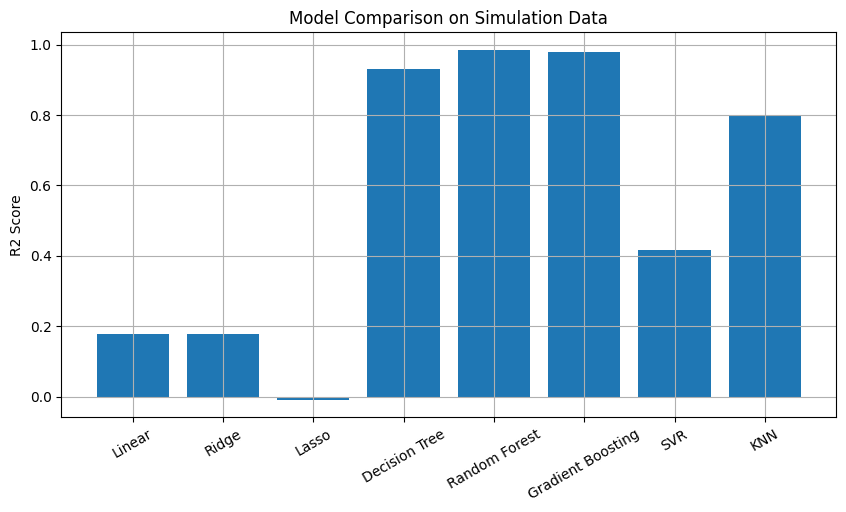

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["R2 Score"])
plt.xticks(rotation=30)
plt.title("Model Comparison on Simulation Data")
plt.ylabel("R2 Score")
plt.grid()
plt.show()
